# Train several models based on an individual's eye images

In [1]:
from cnn_utils import *
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.optimizers import Adam
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [2]:
df = create_dataframe('/../raw_data/dataset_071220.json',image_size=(25,50))
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.43529411764705883, 0.41568627450980394, 0...","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.15294117647058825, 0.12156862745098039, 0...","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.1607843137254902, 0.13333333333333333, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.17254901960784313, 0.12941176470588237, 0...","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.4980392156862745, 0.4627450980392157, 0.5...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


In [4]:
len(df)

950

### Save my personally photos into a file

In [13]:
# with open('pma_indexes.json', 'w') as f:
#     json.dump(list(df_ids["id"].loc[846:950]), f)

In [9]:
# data = requests.get("https://gb.cs.unc.edu/json/drop",headers= { "Accept": "application/json" })
# available_ids = []
# for drop in data.json()['drops']:
#     available_ids.append(drop['id'])

# # There are some bad ids that we have discovered
# # load the recording file and exclude them
# # One can get bad ids from http://patrickma.me/simple_filter/
# with open('bad_indexes.json') as file:
#     bad_ids = json.load(file)

# # get the ids we want to put in our dataframe
# valid_ids = [x for x in available_ids if x not in bad_ids]

# # request data from our API
# allData = []
# for valid_id in valid_ids:
#     data = requests.get('https://gb.cs.unc.edu/json/drop/'+str(valid_id))
#     allData.append(data.json())

In [15]:
# with open('../raw_data/dataset_071220.json', 'w') as f:
#     json.dump(allData, f)

In [16]:
# df = create_dataframe('/../raw_data/dataset_071220.json',image_size=(25,50))
# df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.43529411764705883, 0.41568627450980394, 0...","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.15294117647058825, 0.12156862745098039, 0...","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.1607843137254902, 0.13333333333333333, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.17254901960784313, 0.12941176470588237, 0...","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.4980392156862745, 0.4627450980392157, 0.5...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


## Train on my own data

In [15]:
def test_robustness(df):
    """
    For testing the robustness of our PCA+SVM model when we split the train and test randomly
    """
    train_scores, test_scores = [], []
    for i in range(200):
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.3)

        eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
        eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())
        y_train_binary = create_binary_labels(y_train)
        y_test_binary = create_binary_labels(y_test)

        # reshape to make it possible to feed into SVM
        eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
        eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])
        pca = PCA(n_components=36, whiten=True, random_state=42)
        svc = SVC(kernel='linear', C=0.05)
        svm_model = make_pipeline(pca, svc)
        svm_model.fit(eyeImage_train, y_train_binary)
        # param_grid = {'svc__C': [100,50,10,5,1,0.5,0.1, 0.05, 0.01, 0.005, 0.001]}
        # grid = GridSearchCV(svm_model, param_grid)
        # %time grid.fit(eyeImage_train, y_train_binary)
        # print(grid.best_params_)

        # svm_model = grid.best_estimator_

        train_score = svm_model.score(eyeImage_train, y_train_binary, sample_weight=None)
        test_score = svm_model.score(eyeImage_test, y_test_binary, sample_weight=None)

        train_scores.append(train_score)
        test_scores.append(test_score)
        svm_model = None

    data = {'train_score':train_scores, 'test_score':test_scores}

    return pd.DataFrame(data)

In [13]:
df = create_dataframe('/../raw_data/dataset_pma.json',image_size=(25,50))

In [14]:
result_df = test_robustness(df)

In [16]:
result_df.std(axis=0)

train_score    0.010051
test_score     0.043181
dtype: float64

In [17]:
result_df.mean(axis=0)

train_score    0.990694
test_score     0.921406
dtype: float64

<Figure size 432x288 with 0 Axes>

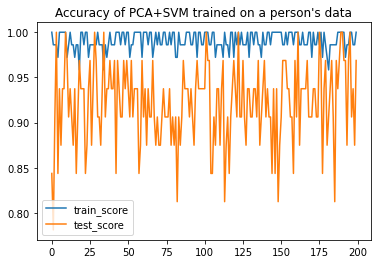

In [19]:
plt.figure()
result_df.plot()
plt.legend(loc="best")
plt.title("Accuracy of PCA+SVM trained on a person's data")
# plt.savefig("results/pca_svm_person_0713.png")